# Performance Comparison of SHA-256, Blake2b, Blake2s, and RSA.

### Author: labry (Justin Park)

## A way to generate an RSA public key pair
openssl genpkey -algorithm RSA -out labry_private.pem -pkeyopt rsa_keygen_bits:2048\
openssl rsa -pubout -in labry_private.pem -out labry_public.pem

In [69]:
from hashcompare import Hash
from hashlib import sha1, sha256, blake2b, blake2s
from zlib import crc32
import time
import inspect
import numpy as np
import copy

In [70]:
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.asymmetric import padding
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.serialization import load_pem_private_key
from cryptography.hazmat.primitives.serialization import load_pem_public_key

In [180]:
class RSA_Hash():
    
    def __init__(self, name):
        self.labryPubKey = load_pem_public_key(
            open('/Users/labry/Downloads/labry_public.pem','rb').read(),
            default_backend())
        
        self.name = name
        self.sha = sha256()
        
    def update(self, data):
        self.sha.update(data)
        self.packet = self.sha.digest()
        #self.packet = data
        
    def digest(self):
            self.ciphertext = self.labryPubKey.encrypt(
                self.packet,
                padding.OAEP(
                    mgf=padding.MGF1(algorithm=hashes.SHA256()),
                    algorithm=hashes.SHA256(),
                    label=None
                )
            )
            return self.ciphertext 

In [182]:
x_range = [1,10,20,30,40,50,60,70,80,90, 100, 110]
#x_range = [15]
names_of_hashes = ['sha256','blake2b','blake2s','rsa-sha256']

rsa = RSA_Hash("rsa-sha256")
hash_mapper = [Hash(sha256(),names_of_hashes[0]), Hash(blake2b(),names_of_hashes[1]),Hash(blake2s(),names_of_hashes[2]), Hash(rsa,names_of_hashes[2])]
hash_mapper = np.array(hash_mapper)

simulated_packet = "abcdefghij"
packet= []

for weight in x_range:
    packet.append(simulated_packet * weight)
    
for idx, hash_f in enumerate(hash_mapper):

    for i in range(len(x_range)):
        hash_mapper[idx].set_start(time.time())
        for j in range(Hash.NUM_OF_ROUNDS):
            #packet = simulated_packet*i
            hash_f.update(packet[i].encode())
            hash_v = hash_f.digest()

        hash_mapper[idx].set_finish(time.time())

    print("{} {} performed {} operations in {} {} \n".format
        (idx, hash_mapper[idx].get_name(), Hash.NUM_OF_ROUNDS,  len(hash_mapper[idx].get_duration()), hash_mapper[idx].get_duration()))

0 sha256 performed 10000 operations in 12 [0.021763086318969727, 0.019660234451293945, 0.022747039794921875, 0.026158809661865234, 0.028717756271362305, 0.033689022064208984, 0.03716397285461426, 0.040405988693237305, 0.042118072509765625, 0.04643821716308594, 0.04790306091308594, 0.05140113830566406] 

1 blake2b performed 10000 operations in 12 [0.015569925308227539, 0.02309584617614746, 0.026061058044433594, 0.028560876846313477, 0.030650854110717773, 0.03776884078979492, 0.024763822555541992, 0.02611398696899414, 0.028738975524902344, 0.03510093688964844, 0.030112028121948242, 0.031687021255493164] 

2 blake2s performed 10000 operations in 12 [0.01170206069946289, 0.01355886459350586, 0.015223979949951172, 0.017187833786010742, 0.018893957138061523, 0.0231931209564209, 0.02486395835876465, 0.02624821662902832, 0.028892993927001953, 0.030658960342407227, 0.04074811935424805, 0.040040016174316406] 

3 blake2s performed 10000 operations in 12 [0.8271300792694092, 0.8154799938201904, 0.

In [183]:
default_duration = np.array(hash_mapper[0].get_duration())

import pandas as pd
import matplotlib.pyplot as plt
default_duration = pd.DataFrame(default_duration)

       sha256   blake2b   blake2s  rsa-sha256
1    0.021763  0.015570  0.011702    0.827130
10   0.019660  0.023096  0.013559    0.815480
20   0.022747  0.026061  0.015224    0.820674
30   0.026159  0.028561  0.017188    0.818491
40   0.028718  0.030651  0.018894    0.851150
50   0.033689  0.037769  0.023193    0.852971
60   0.037164  0.024764  0.024864    0.831112
70   0.040406  0.026114  0.026248    0.837664
80   0.042118  0.028739  0.028893    0.834797
90   0.046438  0.035101  0.030659    0.861546
100  0.047903  0.030112  0.040748    0.854667
110  0.051401  0.031687  0.040040    0.849015


,sha256,blake2b,blake2s


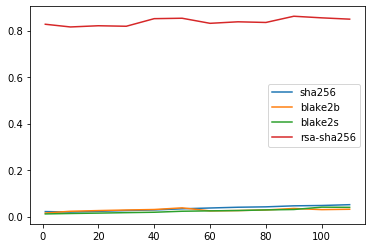

In [257]:

#print(len(x_range))
zero_data = np.zeros(shape=(len(names_of_hashes),1))
zero_series = pd.Series(zero_data[:,0])
#print(zero_series)
plot_result2 = pd.DataFrame({names_of_hashes[0]: zero_series, names_of_hashes[1]: zero_series,
                   names_of_hashes[2]: zero_series}, index=x_range)

#print(plot_result2)
for idx, hash_f in enumerate(hash_mapper):
    plot_result2[names_of_hashes[idx]] = np.array(hash_mapper[idx].get_duration()[0])
    #print(hash_mapper[idx].get_duration())

plot_result2.plot()
print(plot_result2)    


In [270]:
com_result = pd.DataFrame(columns=names_of_hashes[0:-1])

print(hash_mapper[0].get_duration())
print(hash_mapper[1].get_duration())
print(hash_mapper[2].get_duration())
print(hash_mapper[3].get_duration())
temp = hash_mapper[3].get_duration()[0]/hash_mapper[0].get_duration().values[0]
com_result[names_of_hashes[0]] = temp

temp = hash_mapper[3].get_duration()[0]/hash_mapper[1].get_duration().values[0]
com_result[names_of_hashes[1]] = temp

temp = hash_mapper[3].get_duration()[0]/hash_mapper[2].get_duration().values[0]
com_result[names_of_hashes[2]] = temp

com_result

           0
0   0.021763
1   0.019660
2   0.022747
3   0.026159
4   0.028718
5   0.033689
6   0.037164
7   0.040406
8   0.042118
9   0.046438
10  0.047903
11  0.051401
           0
0   0.015570
1   0.023096
2   0.026061
3   0.028561
4   0.030651
5   0.037769
6   0.024764
7   0.026114
8   0.028739
9   0.035101
10  0.030112
11  0.031687
           0
0   0.011702
1   0.013559
2   0.015224
3   0.017188
4   0.018894
5   0.023193
6   0.024864
7   0.026248
8   0.028893
9   0.030659
10  0.040748
11  0.040040
           0
0   0.827130
1   0.815480
2   0.820674
3   0.818491
4   0.851150
5   0.852971
6   0.831112
7   0.837664
8   0.834797
9   0.861546
10  0.854667
11  0.849015


,sha256,blake2b,blake2s
0,38.006102,53.123574,70.682429
1,37.470788,52.375331,69.686871
2,37.709458,52.708935,70.130740
3,37.609130,52.568701,69.944155
4,39.109815,54.666304,72.735076
5,39.193469,54.783233,72.890652
6,38.189065,53.379312,71.022697
7,38.490124,53.800123,71.582596
8,38.358388,53.615987,71.337598
9,39.587483,55.333971,73.623426


In [192]:
plot_result = pd.DataFrame(columns=names_of_hashes)
relative_performance = {}
for idx, hash_f in enumerate(hash_mapper):
    hash_mapper[idx].duration = pd.DataFrame(hash_mapper[idx].get_duration())
    hash_mapper[idx].duration.name = hash_mapper[idx].get_name()

    relative_performance.update({idx: hash_mapper[idx].get_duration()/default_duration})
    alist = []
    for item in relative_performance[idx].values:
        alist.append(item)
    col_name = hash_mapper[idx].get_name()
    data = pd.Series(alist,name=col_name)
    plot_result[col_name] = data.astype(float)

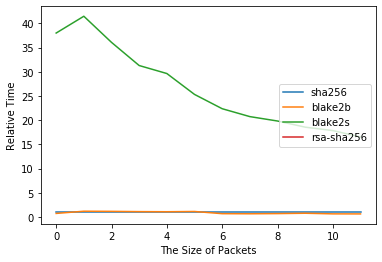

In [193]:
ax = plot_result.plot()
ax.set_xlabel("The Size of Packets")
ax.set_ylabel("Relative Time")
ax.legend(loc='center right')
plt.show()